In [1]:
import os
import rasterio
import requests
from sentinelsat import SentinelAPI
#from skimage import io
import numpy as np
import glob
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.mask import mask
from shapely.geometry import box
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import rasterio
import os
from osgeo import gdal
import leafmap
import rasterio.warp
import pyproj
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd

In [2]:
def download_sentinel(products_df_sorted,output_dir='Anafi'):
    if len(products_df_sorted) > 0:
        # Download the most recent image
        product_id = products_df_sorted.iloc[0]['uuid']
        product_info = api.get_product_odata(product_id)
        download_url = product_info['url']
        product_name = product_info['title']
        #output_dir = 'output_images'
        #os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, product_name)
        if os.path.exists(output_path):
            print(f"The image {product_name} is already downloaded.")
        else:
            api.download(product_id, output_path)

        # Unzip the downloaded file
        unzip_dir = os.path.join(output_dir, product_name, product_name+'.zip')

        try:
            #os.makedirs(unzip_dir, exist_ok=True)
            os.system(f'unzip {unzip_dir} -d {output_path}')
            os.remove(unzip_dir)
        except:
            print('zip has been deleted')
            print(unzip_dir)
        
        # Find the relevant image bands
        safe_dir = os.path.join(output_dir, product_name, f'{product_name}.SAFE')
        print('SAFE dir:',safe_dir)
        band8_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B08.jp2')
        band12_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B12.jp2')
        band4_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B04.jp2')
        band3_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B03.jp2')
        band2_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B02.jp2')
        
        band8_path = glob.glob(band8_path_pattern)
        band12_path = glob.glob(band12_path_pattern)
        band4_path = glob.glob(band4_path_pattern)
        band3_path = glob.glob(band3_path_pattern)
        band2_path = glob.glob(band2_path_pattern)

    else:
        print('No Sentinel-2 images found within the specified bounding box and timeframe.')
    return(band8_path,band12_path,band4_path,band3_path,band2_path)

In [3]:
def create_nbr(band8_path,band12_path,bb):
    b8 = xr.open_dataset(band8_path,engine='rasterio')
    b12 = xr.open_dataset(band12_path)
    b12_resampled = b12.interp_like(b8,method='nearest')
#     b8_reprojected = b8.rio.reproject('epsg:4326')
#     b12_reprojected = b12_resampled.rio.reproject('epsg:4326')
    #b8_reprojected = b8_reprojected.sel(x=slice(bb[0],bb[2]), y = slice(bb[3],bb[1]))
    #b12_reprojected = b12_reprojected.sel(x=slice(bb[0],bb[2]), y = slice(bb[3],bb[1]))   
    #b8_reprojected = b8_reprojected.sel(x=slice(bb[0],bb[2]), y = slice(bb[3],bb[1]))
    #b12_reprojected = b12_reprojected.sel(x=slice(bb[0],bb[2]), y = slice(bb[3],bb[1]))
    #b8_reprojected = b8_reprojected.squeeze()
    #b12_reprojected = b12_reprojected.squeeze()
    nbr = (b8.band_data.values - b12_resampled.band_data.values)/(b8.band_data.values + b12_resampled.band_data.values)
    nbr = nbr.squeeze()
    nbr = xr.DataArray(nbr, coords={'x': b8['x'], 'y': b8['y']}, dims=['y', 'x'])
    nbr = nbr.squeeze()       
    #nbr_crop = nbr.sel(x=slice(bb[0],bb[2]), y = slice(bb[3],bb[1]))
    return(nbr)

In [4]:
def extract_band_paths_from_folder(folder_path):    
    #Find the relevant image bands
    #safe_dir = os.path.join(output_dir, product_name, f'{product_name}.SAFE')
    #print('SAFE dir:',safe_dir)
    band8_path_pattern = os.path.join(folder_path, 'GRANULE', '*', 'IMG_DATA', '*_B08.jp2')
    band12_path_pattern = os.path.join(folder_path, 'GRANULE', '*', 'IMG_DATA', '*_B12.jp2')
    band4_path_pattern = os.path.join(folder_path, 'GRANULE', '*', 'IMG_DATA', '*_B04.jp2')
    band3_path_pattern = os.path.join(folder_path, 'GRANULE', '*', 'IMG_DATA', '*_B03.jp2')
    band2_path_pattern = os.path.join(folder_path, 'GRANULE', '*', 'IMG_DATA', '*_B02.jp2')

    band8_path = glob.glob(band8_path_pattern)
    band12_path = glob.glob(band12_path_pattern)
    band4_path = glob.glob(band4_path_pattern)
    band3_path = glob.glob(band3_path_pattern)
    band2_path = glob.glob(band2_path_pattern)

    return band8_path, band12_path, band4_path, band3_path, band2_path

# Χρησιμοποιήστε την παραπάνω συνάρτηση για να εξάγετε τα μονοκαναλικά αρχεία από έναν φάκελο:
folder_path = '/home/sg/Projects/fires2023/S2B_MSIL1C_20230616T085559_N0509_R007_T35SLA_20230616T093826.SAFE'
band8, band12, band4, band3, band2 = extract_band_paths_from_folder(folder_path)


In [5]:
def run_sentinel_dnbr(footprint,lat,lon,output_dir,raw_crs,date='NOW'):
    try:
        if date == 'NOW':
            print('now')
            #POST FIRE
            products = api.query(footprint, date=('NOW-100DAYS', 'NOW-90DAYS'), platformname='Sentinel-2',
                                 processinglevel='Level-1C', cloudcoverpercentage=(0, 10))
        else:
            end_date = date
            end_date_obj = datetime.strptime(end_date, '%Y%m%d')
            start_date_obj = end_date_obj - timedelta(days=7)
            start_date = start_date_obj.strftime('%Y%m%d')
            products = api.query(footprint, date=(start_date, end_date), platformname='Sentinel-2',
                                 processinglevel='Level-1C', cloudcoverpercentage=(0, 30))
        products_df = api.to_dataframe(products)
        products_df_sorted = products_df.sort_values('ingestiondate', ascending=False)
        tile = products_df_sorted.title.iloc[0].split('_')[5][1:]
        print('Tile:',tile)

        band8_path,band12_path,band4_path,band3_path,band2_path = download_sentinel(products_df_sorted,output_dir=output_dir)
        nbr_post = create_nbr(band8_path[0],band12_path[0],bb)
        nbr_post.to_netcdf(os.path.join(output_dir,'nbr_post.nc'))
        
        #PRE FIRE
        products = api.query(footprint, date=('NOW-150DAYS','NOW-100DAYS'), platformname='Sentinel-2',
                             processinglevel='Level-1C', cloudcoverpercentage=(0, 10))
        products_df = api.to_dataframe(products)
        products_df['tile'] = products_df.title.apply(lambda x: x.split('_')[5][1:])
        products_df = products_df[products_df.tile == tile]
        products_df_sorted = products_df.sort_values('ingestiondate', ascending=False)
        
        
        band8_path,band12_path,band4_path,band3_path,band2_path = download_sentinel(products_df_sorted,output_dir=output_dir)
    
    except:
        print('Product is not online,Triggered retrieval from the Long Term Archive')
        print(extract_band_paths_from_folder)
        band8_path,band12_path,band4_path,band3_path,band2_path = extract_band_paths_from_folder(folder_path)
        
    nbr_pre = create_nbr(band8_path[0],band12_path[0],bb)
    nbr_pre.to_netcdf(os.path.join(output_dir,'nbr_pre.nc'))
    dnbr = nbr_pre - nbr_post
    dnbr.rio.to_raster(os.path.join(output_dir,'dnbr.nc'))
    dnbr.rio.write_crs(raw_crs, inplace=True)
    dnbr_proj = dnbr.rio.reproject('epsg:4326')
    bb_crop = [lon-0.6, lat-0.4, lon+0.6, lat+0.4]
    print(bb_crop)
    dnbr_crop = dnbr_proj.sel(x=slice(bb_crop[0],bb_crop[2]), y = slice(bb_crop[3],bb_crop[1]))
    dnbr_crop.rio.to_raster(os.path.join(output_dir,'dnbr_crop.tif'))
    mask = dnbr_crop > 0.09
    result = dnbr_crop.where(mask)
    result = result.squeeze()
    result = xr.DataArray(result.values, coords={'x': result['x'], 'y': result['y']}, dims=['y', 'x'])
    result = result.to_dataset(name='burned')
    result.to_netcdf(os.path.join(output_dir,'burned.nc'))
    gdal_command = 'gdal_polygonize.py {} -b 1 {}'.format(os.path.join(output_dir,'burned.nc'),os.path.join(output_dir,'burned.shp'))
    os.system(gdal_command)
    polygon = gpd.read_file(os.path.join(output_dir,'burned.shp'))
    polygon = polygon.set_crs(4326)
    polygon = polygon.to_crs(2100)
    polygon = polygon.assign(area=polygon.area)
    print('Total Burned area: ',polygon.area.sum()/10000)
    polygon = polygon[polygon.area>25000]
    polygon_buffer = polygon.buffer(40, join_style=1).buffer(-40.0, join_style=1)
    polygon_buffer = polygon_buffer.simplify(tolerance=5)
    #smoothed_polygons = polygon['geometry'].simplify(tolerance=20) # Adjust the tolerance value as needed
    polygon_buffer.to_file((os.path.join(output_dir,'burned_smoothed_buffer40_simplify5.shp')))
    return polygon_buffer

In [6]:
lat, lon = 36.3942, 25.7614
output_dir='Anafi_{}_{}'.format(lat,lon)
if lon<=24:
    raw_crs = 'epsg:32634'
else:
    raw_crs = 'epsg:32635'
date = 'NOW'

In [7]:
bb = [lon-0.01, lat-0.01, lon+0.01, lat+0.01]

In [8]:
footprint = f'POLYGON(({bb[0]} {bb[1]},{bb[2]} {bb[1]},' \
            f'{bb[2]} {bb[3]},{bb[0]} {bb[3]},' \
            f'{bb[0]} {bb[1]}))'

In [9]:
api = SentinelAPI('stelgirt', '  ', 'https://scihub.copernicus.eu/dhus')

In [10]:
polygon = run_sentinel_dnbr(footprint,lat,lon,output_dir,raw_crs,date=date)

now
Product is not online,Triggered retrieval from the Long Term Archive
<function extract_band_paths_from_folder at 0x7f3ba5d9aa60>


IndexError: list index out of range

# Create rgb

In [10]:
safe_dir = '/home/sg/Projects/fires2023/arioxvri_37.1815_21.8722/S2B_MSIL1C_20230821T091559_N0509_R093_T34SEG_20230821T112732/S2B_MSIL1C_20230821T091559_N0509_R093_T34SEG_20230821T112732.SAFE'

In [11]:
output_dir= '/home/sg/Projects/fires2023/arioxvri_37.1815_21.8722/'

In [12]:
lat, lon = 37.1815, 21.8722
bb_crop = [lon-0.1, lat-0.1, lon+0.1, lat+0.1]

In [13]:
band4_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B04.jp2')
band3_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B03.jp2')
band2_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B02.jp2')

band4_path = glob.glob(band4_path_pattern)[0]
band3_path = glob.glob(band3_path_pattern)[0]
band2_path = glob.glob(band2_path_pattern)[0]

In [14]:
band4 = xr.open_dataset(band4_path)
band3 = xr.open_dataset(band3_path)
band2 = xr.open_dataset(band2_path)

In [15]:
command = 'gdalbuildvrt -separate {}rgb.vrt {} {} {}'.format(output_dir, band4_path,band3_path,band2_path)

In [16]:
os.system(command)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [17]:
command = 'gdal_translate {}rgb.vrt {}out.jpg'.format(output_dir,output_dir)

In [18]:
os.system(command)

Input file size is 10980, 10980
0

Warning 1: One or more pixels clipped to fit 12bit domain for jpeg output.


...10...20...30...40...50...60...70...80...90...100 - done.


0

In [19]:
command = 'gdal_merge.py -separate -o {}rgb_composite.tif {} {} {}'.format(output_dir, band4_path,band3_path,band2_path)

In [20]:
os.system(command)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [11]:
safe_dir = '/home/sg/Projects/fires2023/arioxvri_37.1815_21.8722/S2B_MSIL1C_20230910T091559_N0509_R093_T34SEG_20230910T115323/S2B_MSIL1C_20230910T091559_N0509_R093_T34SEG_20230910T115323.SAFE'
output_dir= '/home/sg/Projects/fires2023/arioxvri_37.1815_21.8722/'

In [12]:
lat, lon = 37.1815, 21.8722
bb_crop = [lon-0.1, lat-0.1, lon+0.1, lat+0.1]

In [13]:
band4_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B04.jp2')
band3_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B03.jp2')
band2_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B02.jp2')

band4_path = glob.glob(band4_path_pattern)[0]
band3_path = glob.glob(band3_path_pattern)[0]
band2_path = glob.glob(band2_path_pattern)[0]

In [14]:
band4 = xr.open_dataset(band4_path)
band3 = xr.open_dataset(band3_path)
band2 = xr.open_dataset(band2_path)

In [15]:
command = 'gdalbuildvrt -separate {}rgb.vrt {} {} {}'.format(output_dir, band4_path,band3_path,band2_path)
os.system(command)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [16]:
command = 'gdal_translate {}rgb.vrt {}out.jpg'.format(output_dir,output_dir)
os.system(command)

Input file size is 10980, 10980
0

Warning 1: One or more pixels clipped to fit 12bit domain for jpeg output.


...10...20...30...40...50...60...70...80...90...100 - done.


0

In [17]:
command = 'gdal_merge.py -separate -o {}rgb_composite_post.tif {} {} {}'.format(output_dir, band4_path,band3_path,band2_path)
os.system(command)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

# Create false color

In [28]:
safe_dir = '/home/sg/Projects/fires2023/kilkis_41.1421_22.6327/S2A_MSIL1C_20230826T092031_N0509_R093_T34TFL_20230826T113242/S2A_MSIL1C_20230826T092031_N0509_R093_T34TFL_20230826T113242.SAFE'
output_dir= '/home/sg/Projects/fires2023/kilkis_41.1421_22.6327/'

In [29]:
band12_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B12.jp2')
band11_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B11.jp2')
band4_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B04.jp2')

band12_path = glob.glob(band12_path_pattern)[0]
band11_path = glob.glob(band11_path_pattern)[0]
band4_path = glob.glob(band4_path_pattern)[0]

In [30]:
band12 = xr.open_dataset(band12_path)
band11 = xr.open_dataset(band11_path)
band4 = xr.open_dataset(band4_path)

In [31]:
command = 'gdalbuildvrt -separate {}false_color_pre.vrt {} {} {}'.format(output_dir, band12_path,band11_path,band4_path)
os.system(command)
command = 'gdal_translate {}false_color_pre.vrt {}out_pre.jpg'.format(output_dir,output_dir)
os.system(command)
command = 'gdal_merge.py -separate -o {}false_color_composite_pre.tif {} {} {}'.format(output_dir, band12_path,band11_path,band4_path)
os.system(command)

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 6588, 6588
0

Warning 1: One or more pixels clipped to fit 12bit domain for jpeg output.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [18]:
safe_dir = '/home/sg/Projects/fires2023/arioxvri_37.1815_21.8722/S2B_MSIL1C_20230910T091559_N0509_R093_T34SEG_20230910T115323/S2B_MSIL1C_20230910T091559_N0509_R093_T34SEG_20230910T115323.SAFE'
output_dir= '/home/sg/Projects/fires2023/arioxvri_37.1815_21.8722/'

In [19]:
band12_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B12.jp2')
band11_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B11.jp2')
band4_path_pattern = os.path.join(safe_dir, 'GRANULE', '*', 'IMG_DATA', '*_B04.jp2')

band12_path = glob.glob(band12_path_pattern)[0]
band11_path = glob.glob(band11_path_pattern)[0]
band4_path = glob.glob(band4_path_pattern)[0]

In [20]:
band12 = xr.open_dataset(band12_path)
band11 = xr.open_dataset(band11_path)
band4 = xr.open_dataset(band4_path)

In [21]:
command = 'gdalbuildvrt -separate {}false_color_post.vrt {} {} {}'.format(output_dir, band12_path,band11_path,band4_path)
os.system(command)
command = 'gdal_translate {}false_color_post.vrt {}out_post.jpg'.format(output_dir,output_dir)
os.system(command)
command = 'gdal_merge.py -separate -o {}false_color_composite_post.tif {} {} {}'.format(output_dir, band12_path,band11_path,band4_path)
os.system(command)

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 6588, 6588
0

Warning 1: One or more pixels clipped to fit 12bit domain for jpeg output.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


0

# comparison

In [178]:
img1 = '/home/sg/Projects/fires2023/andros_pre.jpeg'
img2 = "/home/sg/Projects/fires2023/andros_post.jpeg"

In [179]:
leafmap.image_comparison(
    img1,
    img2,
    label1='Pre fire',
    label2='Post fire',
    starting_position=50,
    out_html='image_comparison.html',
)

ImportError: Please run 'pip install -U scikit-image imagecodecs' for large image handling.

In [ ]:
band2_path

In [ ]:
band_02=rasterio.open(band2_path)
band_03=rasterio.open(band3_path)
band_04=rasterio.open(band4_path)

In [ ]:
red = band_04.read(1)
green = band_03.read(1)
blue = band_02.read(1)

In [ ]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))
def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0,255)

red_b=brighten(red)
blue_b=brighten(blue)
green_b=brighten(green)

red_bn = normalize(red_b)
green_bn = normalize(green_b)
blue_bn = normalize(blue_b)

In [ ]:
rgb_composite_n= np.dstack((red, green, blue))

In [ ]:
plt.imshow(rgb_composite_n)

# Land_use_land_cover

In [93]:
from osgeo import gdal

In [122]:
shapefile = gpd.read_file('/home/sg/Projects/fires2023/fires_2023_july_august.shp')

In [124]:
shapefile = shapefile[shapefile.city=='Rodos']

In [125]:
shapefile = shapefile.to_crs(epsg=3035)

In [126]:
corine = gpd.read_file('/home/sg/Downloads/1cefc5e87d3cecf0f145fc4d0823668669f51423/u2018_clc2018_v2020_20u1_geoPackage/DATA/corine_greece.shp')

In [127]:
#codes = pd.read_csv('/home/sg/Projects/FIrehub-model/no_fire_90/CLC_codes.csv')

In [128]:
labels = pd.read_csv('/home/sg/Downloads/1cefc5e87d3cecf0f145fc4d0823668669f51423/clc_test.csv')

In [129]:
labels = pd.read_csv('/home/sg/Downloads/1cefc5e87d3cecf0f145fc4d0823668669f51423/clc_legend.csv', encoding = 'iso8859_7')

In [130]:
#for i in range(len(shapefile)+1):
    #shapefile_1 = shapefile.loc[i]
    #shapefile_1_df = gpd.GeoDataFrame([shapefile], crs=shapefile.crs)
clipped_corine_gdf = gpd.clip(corine, shapefile)
labels['CLC_CODE'] = labels['CLC_CODE'].astype(str)
clipped_corine_gdf = clipped_corine_gdf.merge(labels, left_on='Code_18', right_on='CLC_CODE')
clipped_corine_gdf = clipped_corine_gdf.assign(area=clipped_corine_gdf.area)
corine_grouped = clipped_corine_gdf.groupby('CLC_CODE')['area'].sum().reset_index()
corine_grouped['area'] = corine_grouped['area']/10000
corine_grouped = corine_grouped.merge(labels, left_on='CLC_CODE', right_on='CLC_CODE')
corine_grouped['percentage'] = corine_grouped.area.apply(lambda x: (x/corine_grouped.area.sum())*100)
#print(shapefile_rodos.city)
print(corine_grouped[['LABEL3GR','area','percentage']])

                                             LABEL3GR         area  percentage
0                              Ασυνεχής αστικός ιστός     7.598890    0.042662
1               Εγκαταστάσεις αθλητισμού και αναψυχής    25.841323    0.145080
2                            Μη αρδευόμενη αρόσιμη γη   129.873482    0.729142
3   Οπωροφόρα δένδρα και φυτείες με σαρκώδεις καρπούς     0.758888    0.004261
4                                            Ελαιώνες   789.054090    4.429944
5                               Σύνθετες καλλιέργειες   231.433250    1.299323
6   Γη που χρησιμοποιείται κυρίως για γεωργία μαζί...  2208.816300   12.400840
7                                     Δάσος κωνοφόρων  1416.440308    7.952245
8                                  Φυσικοί βοσκότοποι  1263.420307    7.093153
9                              Σκληροφυλλική βλάστηση  3925.507120   22.038766
10        Μεταβατικές δασώδεις και θαμνώδεις εκτάσεις  7789.609989   43.732793
11                     Παραλίες, αμμόλοφοι, Αμμουδιέ

<AxesSubplot: ylabel='percentage'>

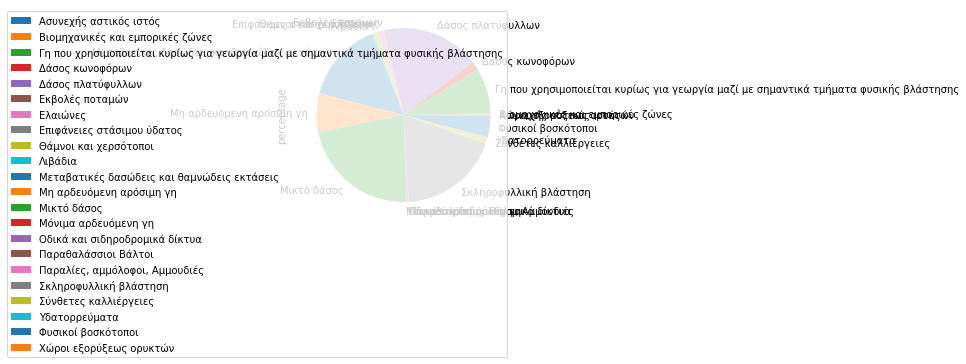

In [107]:
corine_grouped.groupby(['LABEL3GR']).sum().plot(kind='pie', y='percentage')

# Ανάλυση ανά νομό

In [23]:
plt.rcParams['font.family'] = 'Arial Unicode MS'

In [30]:
# Step 1: Read the shapefiles
burned_areas_shapefile = '/home/sg/Projects/fires2023/fires_2023_july_august.shp'
#prefectures_shapefile = '/home/sg/Downloads/oriadhmwnkallikraths/oria_dhmwn_kallikraths/oria_dhmwn_kallikraths.shp'
prefectures_shapefile = '/home/sg/Downloads/periphereies/periphereies.shp'

In [31]:
burned_areas = gpd.read_file(burned_areas_shapefile)
prefectures = gpd.read_file(prefectures_shapefile,encoding = 'iso8859_7')

In [34]:
plt.rcParams['font.family'] = 'DejaVu Sans'

In [35]:
burned_areas_split = gpd.clip(prefectures, burned_areas)

In [36]:
burned_areas_split

,PER,geometry
6,Π. ΝΟΤΙΟΥ ΑΙΓΑΙΟΥ,"MULTIPOLYGON (((859711.691 3998350.749, 859718..."
12,Π. ΑΤΤΙΚΗΣ,"MULTIPOLYGON (((452585.159 4224577.498, 452586..."
1,Π. ΚΕΝΤΡΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ,"POLYGON ((449697.150 4466929.872, 449716.574 4..."
0,Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ,"MULTIPOLYGON (((641952.467 4524482.453, 641972..."
9,Π. ΠΕΛΟΠΟΝΝΗΣΟΥ,"MULTIPOLYGON (((369070.514 4091462.867, 369099..."
8,Π. ΔΥΤΙΚΗΣ ΕΛΛΑΔΑΣ,"MULTIPOLYGON (((340787.570 4224112.801, 340778..."
7,Π. ΣΤΕΡΕΑΣ ΕΛΛΑΔΑΣ,"MULTIPOLYGON (((351935.779 4345025.498, 351946..."
10,Π. ΙΟΝΙΩΝ ΝΗΣΩΝ,"POLYGON ((149067.026 4412509.998, 149066.880 4..."
4,Π. ΘΕΣΣΑΛΙΑΣ,"MULTIPOLYGON (((354312.089 4343962.498, 354059..."


In [37]:
burned_areas_split['burned_area'] = burned_areas_split['geometry'].area/10000

In [39]:
attica = burned_areas_split[burned_areas_split.PER == 'Π. ΑΤΤΙΚΗΣ']

In [69]:
rodos = burned_areas_split[burned_areas_split.PER =='Π. ΝΟΤΙΟΥ ΑΙΓΑΙΟΥ']

In [91]:
evros = burned_areas_split[burned_areas_split.PER =='Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ']

<AxesSubplot: >

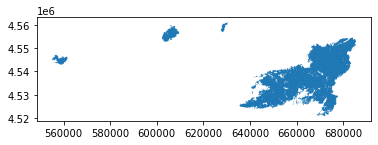

In [92]:
evros.plot()

In [40]:
burned_areas_split = burned_areas_split.groupby('NAME')['burned_area'].sum()
print(burned_areas_split)

KeyError: 'NAME'

In [216]:
clipped_corine_burned_areas = gpd.clip(corine, burned_areas_split)

In [218]:
clipped_corine_burned_areas['burned_area'] = clipped_corine_burned_areas['geometry'].area/10000

In [228]:
clc_joined = gpd.sjoin(clipped_corine_burned_areas, prefectures)

In [248]:
clc_joined

,OBJECTID,Code_18,Remark,Area_Ha,ID,geometry,burned_area,index_right,NAME,KWD_YPES
834,630671.0,112,NaN,1566.460344,EU_630671,"MULTIPOLYGON (((495247.673 4177803.103, 495191...",119.151073,272,Σαρωνικού,9225
33591,663770.0,323,NaN,480.351462,EU_663770,"POLYGON ((491998.565 4180480.315, 491936.391 4...",324.347102,272,Σαρωνικού,9225
43736,673936.0,334,NaN,374.540308,EU_673936,"POLYGON ((493973.786 4179975.536, 493999.384 4...",372.287498,272,Σαρωνικού,9225
33589,663768.0,323,NaN,121.682249,EU_663768,"POLYGON ((495413.986 4178934.715, 495419.956 4...",99.988975,272,Σαρωνικού,9225
12447,642541.0,242,NaN,1309.359077,EU_642541,"MULTIPOLYGON (((494646.750 4182118.030, 494636...",499.846211,272,Σαρωνικού,9225
...,...,...,...,...,...,...,...,...,...,...
35936,666115.0,323,NaN,51.458115,EU_666115,"POLYGON ((398828.663 4359173.587, 398750.383 4...",51.426623,263,Ρήγα Φερραίου,9108
3202,633064.0,121,NaN,154.329108,EU_633064,"MULTIPOLYGON (((397847.959 4360611.524, 397809...",0.994961,263,Ρήγα Φερραίου,9108
30694,660870.0,321,NaN,83.951556,EU_660870,"POLYGON ((400140.455 4360779.060, 399995.895 4...",58.989985,263,Ρήγα Φερραίου,9108
7124,637145.0,222,NaN,858.489008,EU_637145,"MULTIPOLYGON (((401458.448 4361370.450, 401442...",331.750147,263,Ρήγα Φερραίου,9108


In [254]:
for i,a in enumerate(clc_joined.NAME.unique()):
    clc_sel = clc_joined[clc_joined.NAME==a]
    clc_sel['percentage'] = clc_sel.area.apply(lambda x: (x/clc_sel.area.sum())*100)
    clc_sel_joined=clc_sel.groupby(['Code_18','NAME'])['percentage'].sum().reset_index()
    clc_sel_joined['Code_18'] = clc_sel_joined['Code_18'].astype('int')
    final = clc_sel_joined.merge(clc_nom_greek, left_on='Code_18', right_on='Code_18')
    sorted_df = final.sort_values(by='percentage')
    if i == 0:
        sorted_df.to_csv('clc_nomoi.csv',index=False)
    else:
        sorted_df.to_csv('clc_nomoi.csv',index=False, mode='a', header=False)
#print(a, final[[name,percentage]])

In [244]:
clc_sel_joined

pandas.core.frame.DataFrame

In [245]:
clc_nom_greek = pd.read_csv('clc_nom_greek.csv')

In [246]:
clc_nom_greek['Code_18'] = clc_nom_greek['Code_18'].astype('int')
clc_sel_joined['Code_18'] = clc_sel_joined['Code_18'].astype('int')

In [247]:
clc_sel_joined.merge(clc_nom_greek, left_on='Code_18', right_on='Code_18')

,Code_18,NAME,percentage,name
0,112,Ρήγα Φερραίου,0.088054,∆ιακεκοµµένη αστική οικοδόµηση
1,121,Ρήγα Φερραίου,0.015031,Βιοµηχανικές ή εµπορικές ζώνες
2,122,Ρήγα Φερραίου,0.629486,Οδικά και σιδηροδροµικά δίκτυα και γειτνιάζουσ...
3,131,Ρήγα Φερραίου,0.472390,Χώροι εξόρυξης ορυκτών
4,211,Ρήγα Φερραίου,25.964982,Μη αρδεύσιµη-αρόσιµη γη
5,212,Ρήγα Φερραίου,7.559361,Μόνιµα αρδευόµενη γη
6,222,Ρήγα Φερραίου,5.011642,Οπωροφόρα δέντρα και φυτείες µε σαρκώδεις καρπούς
7,242,Ρήγα Φερραίου,5.115001,Σύνθετα συστήµατα καλλιέργειας
8,243,Ρήγα Φερραίου,4.335406,Γη που καλύπτεται κυρίως από γεωργία µε σηµαντ...
9,321,Ρήγα Φερραίου,8.315892,Φυσικοί βοσκότοποι


In [224]:
corine_grouped = clipped_corine_gdf.groupby('Class')['area'].sum().reset_index()
corine_grouped['area'] = corine_grouped['area']/10000
corine_grouped = corine_grouped.merge(nom, left_on='Class', right_on='Class')
corine_grouped['percentage'] = corine_grouped.area.apply(lambda x: (x/corine_grouped.area.sum())*100)
#print(shapefile_1.city)
print(corine_grouped[[' Description','percentage']])

                                   Description  percentage
0   Road and Rail Networks and Associated Land    0.435925
1                 Sport and Leisure Facilities    1.621806
2            Fruit Trees and Berry Plantations    5.805846
3                                 Olive Groves   19.615582
4                            Coniferous Forest   11.084285
5                    Sclerophyllous Vegetation   12.375942
6                  Transitional Woodland-Shrub   49.060616


In [226]:
clc_joined

,OBJECTID,Code_18,Remark,Area_Ha,ID,geometry,burned_area,index_right,NAME,KWD_YPES
834,630671.0,112,NaN,1566.460344,EU_630671,"MULTIPOLYGON (((495247.673 4177803.103, 495191...",119.151073,272,Σαρωνικού,9225
33591,663770.0,323,NaN,480.351462,EU_663770,"POLYGON ((491998.565 4180480.315, 491936.391 4...",324.347102,272,Σαρωνικού,9225
43736,673936.0,334,NaN,374.540308,EU_673936,"POLYGON ((493973.786 4179975.536, 493999.384 4...",372.287498,272,Σαρωνικού,9225
33589,663768.0,323,NaN,121.682249,EU_663768,"POLYGON ((495413.986 4178934.715, 495419.956 4...",99.988975,272,Σαρωνικού,9225
12447,642541.0,242,NaN,1309.359077,EU_642541,"MULTIPOLYGON (((494646.750 4182118.030, 494636...",499.846211,272,Σαρωνικού,9225
...,...,...,...,...,...,...,...,...,...,...
35936,666115.0,323,NaN,51.458115,EU_666115,"POLYGON ((398828.663 4359173.587, 398750.383 4...",51.426623,263,Ρήγα Φερραίου,9108
3202,633064.0,121,NaN,154.329108,EU_633064,"MULTIPOLYGON (((397847.959 4360611.524, 397809...",0.994961,263,Ρήγα Φερραίου,9108
30694,660870.0,321,NaN,83.951556,EU_660870,"POLYGON ((400140.455 4360779.060, 399995.895 4...",58.989985,263,Ρήγα Φερραίου,9108
7124,637145.0,222,NaN,858.489008,EU_637145,"MULTIPOLYGON (((401458.448 4361370.450, 401442...",331.750147,263,Ρήγα Φερραίου,9108


# Natura

In [14]:
intersection_gdf

,id,city,area,layer,path,SITECODE,SITENAME,RELEASE_DA,MS,SITETYPE,INSPIRE_ID,geometry,burned_area
0,NaN,NaN,6433.520,fires_2023_august,/home/sg/Projects/fires2023/fires_2023_august.shp,GR3000001,OROS PARNITHA,2021-12-14,GR,C,NaN,"MULTIPOLYGON (((5526471.833 1781979.640, 55264...",3.025821e+07
1,NaN,NaN,2300.850,fires_2023_august,/home/sg/Projects/fires2023/fires_2023_august.shp,GR2530007,KORINTHIAKOS KOLPOS,2021-12-14,GR,B,NaN,"MULTIPOLYGON (((5432171.332 1786551.253, 54321...",2.711458e+02
2,NaN,NaN,1950.640,fires_2023_august,/home/sg/Projects/fires2023/fires_2023_august.shp,GR2530007,KORINTHIAKOS KOLPOS,2021-12-14,GR,B,NaN,"MULTIPOLYGON (((5452439.658 1776875.342, 54524...",3.944589e+04
3,NaN,NaN,68470.800,fires_2023_august,/home/sg/Projects/fires2023/fires_2023_august.shp,GR1110005,VOUNA EVROU- POTAMOS LYRAS- SPILAIA DIDYMOTEIC...,2021-12-14,GR,B,NaN,"MULTIPOLYGON (((5665601.382 2143513.363, 56656...",1.347377e+08
4,NaN,NaN,68470.800,fires_2023_august,/home/sg/Projects/fires2023/fires_2023_august.shp,GR1110006,DELTA EVROU,2021-12-14,GR,A,NaN,"MULTIPOLYGON (((5670477.727 2113787.064, 56704...",3.251805e+06
5,NaN,NaN,68470.800,fires_2023_august,/home/sg/Projects/fires2023/fires_2023_august.shp,GR1110002,DASOS DADIAS - SOUFLI,2021-12-14,GR,A,NaN,"MULTIPOLYGON (((5665601.382 2143513.363, 56656...",1.347377e+08
6,NaN,NaN,68470.800,fires_2023_august,/home/sg/Projects/fires2023/fires_2023_august.shp,GR1110009,NOTIO DASIKO SYMPLEGMA EVROU,2021-12-14,GR,A,NaN,"MULTIPOLYGON (((5647098.805 2128927.380, 56471...",2.318436e+08
7,NaN,NaN,68470.800,fires_2023_august,/home/sg/Projects/fires2023/fires_2023_august.shp,GR1110003,TREIS VRYSES,2021-12-14,GR,B,NaN,"POLYGON ((5660461.753 2142916.532, 5660500.749...",1.352950e+07
8,NaN,NaN,68470.800,fires_2023_august,/home/sg/Projects/fires2023/fires_2023_august.shp,GR1110007,DELTA EVROU KAI DYTIKOS VRACHIONAS,2021-12-14,GR,B,NaN,"MULTIPOLYGON (((5670477.727 2113787.064, 56704...",3.251805e+06
9,NaN,NaN,68470.800,fires_2023_august,/home/sg/Projects/fires2023/fires_2023_august.shp,GR1110010,OREINOS EVROS - KOILADA DEREIOU,2021-12-14,GR,A,NaN,"POLYGON ((5660461.753 2142916.532, 5660500.749...",1.352950e+07


<AxesSubplot: >

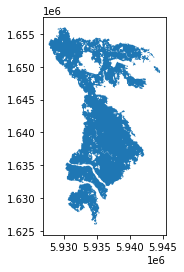

In [138]:
shapefile.plot()

In [52]:
# Load shapefiles
natura_file = "/home/sg/Downloads/eea_v_3035_100_k_natura2000_p_2021_v12_r00/SHP/Natura2000_end2021_epsg3035.shp"
burned_file = "/home/sg/Projects/fires2023/fires_2023_july_august.shp"
#burned_gdf = shapefile


natura_gdf = gpd.read_file(natura_file)
burned_gdf = gpd.read_file(burned_file)


In [53]:
#burned_gdf = evros
burned_gdf = burned_gdf.to_crs(epsg=3035)

In [54]:
# Perform spatial intersection
intersection_gdf = gpd.overlay(burned_gdf, natura_gdf, how="intersection")

# Calculate burned area
intersection_gdf['area'] = intersection_gdf.geometry.area

# Calculate total area of burned polygons
total_burned_area = burned_gdf.geometry.area.sum()

In [55]:
# Calculate total area of burned polygons within Natura 2000 polygons
total_burned_area_in_natura = intersection_gdf['area'].sum()

# Calculate percentage
percentage_burned_in_natura = (total_burned_area_in_natura / total_burned_area) * 100
print(f"Percentage of burned area in Natura areas: {percentage_burned_in_natura:.2f}%")


# Get names of Natura areas affected
affected_natura_names = list(intersection_gdf['SITENAME'])

print("Natura areas affected by the burn:")
for name in affected_natura_names:
    print(name)

Percentage of burned area in Natura areas: 50.40%
Natura areas affected by the burn:
KORINTHIAKOS KOLPOS
KORINTHIAKOS KOLPOS
LIMNES YLIKI KAI PARALIMNI – SYSTIMA VOIOTIKOU KIFISOU -KATAVOTHRA ALIARTOU
KOILADA KAI EKVOLES SPERCHEIOU – MALIAKOS KOLPOS – MESOCHORI SPERCHEIOU
OROS VARASOVA
DELTA ACHELOOU, LIMNOTHALASSA MESOLONGIOU - AITOLIKOU, EKVOLES EVINOU, NISOI ECHINADES, NISOS PETALAS
DELTA ACHELOOU, LIMNOTHALASSA MESOLONGIOU - AITOLIKOU KAI EKVOLES EVINOU, NISOI ECHINADES, NISOS PETALAS, DYTIKOS ARAKYNTHOS KAI STENA KLEISOURAS
OROS OCHI – KAMPOS KARYSTOU – POTAMI – AKROTIRIO KAFIREFS – PARAKTIA THALASSIA ZONI
OROS OCHI, PARAKTIA ZONI KAI NISIDES
ANATOLIKI RODOS: PROFITIS ILIAS - EPTA PIGES - EKVOLI LOUTANI - KATERGO, REMA GADOURA - CHERSONISOS LINDOU - NISIDES PENTANISA KAI TETRAPOLIS, LOFOS PSALIDI
RODOS: AKRAMYTIS, ARMENISTIS, ATTAVYROS, REMATA KAI THALASSIA ZONI (KARAVOLA-ORMOS GLYFADA)
FARANGI VOURAIKOU
OROS CHELMOS (AROANIA) - FARANGI VOURAIKOU KAI PERIOCHI KALAVRYTON
KENTRIKI K

In [56]:
percentage_burned_in_natura

50.40004257609314

In [144]:
intersection_gdf['area'] = intersection_gdf.geometry.area/10000

In [145]:
dissolved = intersection_gdf.dissolve()

In [146]:
dissolved['area'] = dissolved.geometry.area/10000

In [147]:
dissolved

,geometry,id,city,area,layer,path,SITECODE,SITENAME,RELEASE_DA,MS,SITETYPE,INSPIRE_ID
0,"MULTIPOLYGON (((5936157.164 1636804.040, 59361...",NaN,Rodos,440.229328,fires_2023_july,/home/sg/Projects/fires2023/fires_2023_july.shp,GR4210029,ANATOLIKI RODOS: PROFITIS ILIAS - EPTA PIGES -...,2021-12-14,GR,A,NaN


# BSM

In [102]:
# Load shapefiles
bsm_file = "/home/sg/Desktop/bsm_1984_2022.shp"
burned_file = "/home/sg/Projects/fires2023/fires_2023_july_august.shp"


bsm_gdf = gpd.read_file(bsm_file)
burned_gdf = gpd.read_file(burned_file)


In [103]:
bsm_gdf = bsm_gdf[bsm_gdf.year>=2007]
bsm_gdf = bsm_gdf.to_crs(epsg=2100)

In [104]:
natura_gdf.year.max()

2022

In [105]:
burned_gdf = evros

In [106]:

# Perform spatial intersection
intersection_gdf = gpd.overlay(burned_gdf, bsm_gdf, how="intersection")

# Calculate burned area
intersection_gdf['area'] = intersection_gdf.geometry.area

# Calculate total area of burned polygons
total_burned_area = burned_gdf.geometry.area.sum()

In [107]:
# Calculate total area of burned polygons within Natura 2000 polygons
total_burned_area_in_bsm = intersection_gdf['area'].sum()

# Calculate percentage
percentage_burned_in_bsm = (total_burned_area_in_bsm / total_burned_area) * 100

print(f"Percentage of burned area that was burned before: {percentage_burned_in_bsm:.2f}%")

Percentage of burned area that was burned before: 8.50%
